## Health Care for All Case Study using Pandas

In [293]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import statsmodels.api as sm#lm model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
pd.options.display.max_rows = 50

## Install xlrd package to load Excel files
# conda install openpyxl
## conda install xlrd

In [234]:
RAND_STATE = 34 # for reproducible shuffling
TT_RATIO = 0.3 # test/train

In [327]:
from scipy.stats import iqr
def remove_outliers(df):
    for c in df.columns:
            pct_75 = np.percentile(df[c], 75)
            pct_25 = np.percentile(df[c], 25)
            upper_bound = pct_75 + 1.5*iqr(df[c])
            lower_bound = pct_25 - 1.5*iqr(df[c])
            condition = (df[c] < upper_bound) & (df[c] > lower_bound)
            df[c] = df[c][condition]  # Filter out the outliers
    return df

<b> We begin by loading the precleaned data set

In [236]:
#hk_df= pd.read_csv("hk_df_cleaned.csv")
df = pd.read_csv('Data_Marketing_Customer_Analysis_Round3.csv')
df


,region,customer_lifetime_value,response,coverage,education,effective_to_date,month,employment_status,gender,income,...,months_since_policy_inception,number_of_open_complaints,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,total_claim_amount,vehicle_class,vehicle_size
0,central,4809,no,basic,college,2/18/11,feb,employed,m,48029,...,52,0,9,corporate auto,corporate l3,offer3,agent,292,four-door car,medsize
1,west region,2228,no,basic,college,1/18/11,jan,unemployed,f,92260,...,26,0,1,personal auto,personal l3,offer4,call center,744,four-door car,medsize
2,east,14947,no,basic,bachelor,2/10/11,feb,employed,m,22139,...,31,0,2,personal auto,personal l3,offer3,call center,480,suv,medsize
3,north west,22332,yes,extended,college,1/11/11,jan,employed,m,49078,...,3,0,2,corporate auto,corporate l3,offer2,branch,484,four-door car,medsize
4,north west,9025,no,premium,bachelor,1/17/11,jan,medical leave,f,23675,...,31,0,7,personal auto,personal l2,offer1,branch,707,four-door car,medsize
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10684,central,15563,no,premium,bachelor,1/19/11,jan,unemployed,f,61541,...,40,0,7,personal auto,personal l1,offer3,web,1214,luxury car,medsize
10685,north west,5259,no,basic,college,1/6/11,jan,employed,f,61146,...,68,0,6,personal auto,personal l3,offer2,branch,273,four-door car,medsize
10686,central,23893,no,extended,bachelor,2/6/11,feb,employed,f,39837,...,63,0,2,corporate auto,corporate l3,offer1,web,381,luxury suv,medsize
10687,west region,11971,no,premium,college,2/13/11,feb,employed,f,64195,...,27,4,6,personal auto,personal l1,offer1,branch,618,suv,medsize


In [237]:
df.columns # inspect the column names

Index(['region', 'customer_lifetime_value', 'response', 'coverage',
       'education', 'effective_to_date', 'month', 'employment_status',
       'gender', 'income', 'location_code', 'marital_status',
       'monthly_premium_auto', 'months_since_last_claim',
       'months_since_policy_inception', 'number_of_open_complaints',
       'number_of_policies', 'policy_type', 'policy', 'renew_offer_type',
       'sales_channel', 'total_claim_amount', 'vehicle_class', 'vehicle_size'],
      dtype='object')

<b> checking correlations between numerical variables

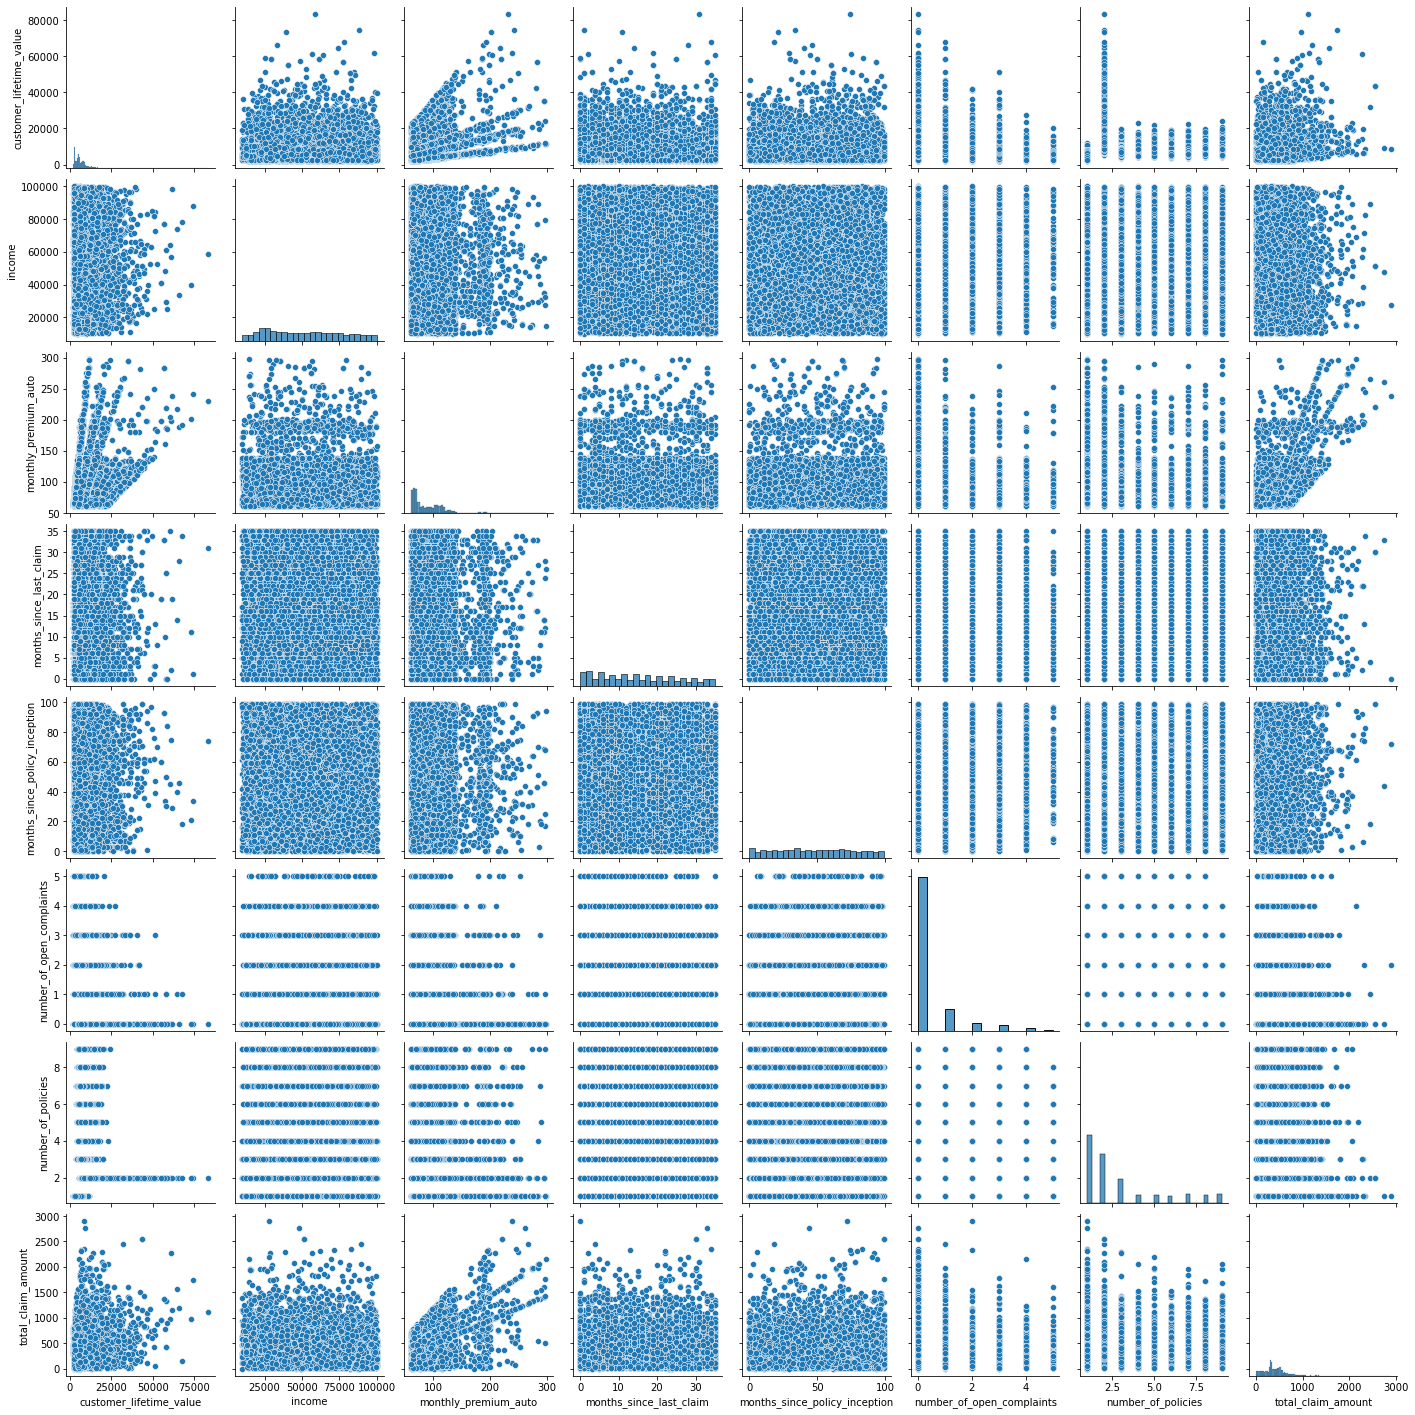

In [238]:
#sns.pairplot(hk_df.select_dtypes(np.number)) # pairplot generates a grid of scatter plots for all numerical variables except on the diagonal where it displays distributions
sns.pairplot(df.select_dtypes(np.number))

<b> plotting the correlation heatmap

In [239]:
#corr = hk_df.corr()
#mask = np.zeros_like(corr)
#mask[np.triu_indices_from(mask)] = True # trick to filter out the upper-right triangle, which is redundant due to symmetry
#with sns.axes_style("white"):
 #   f, ax = plt.subplots(figsize=(16, 14))
  #  ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

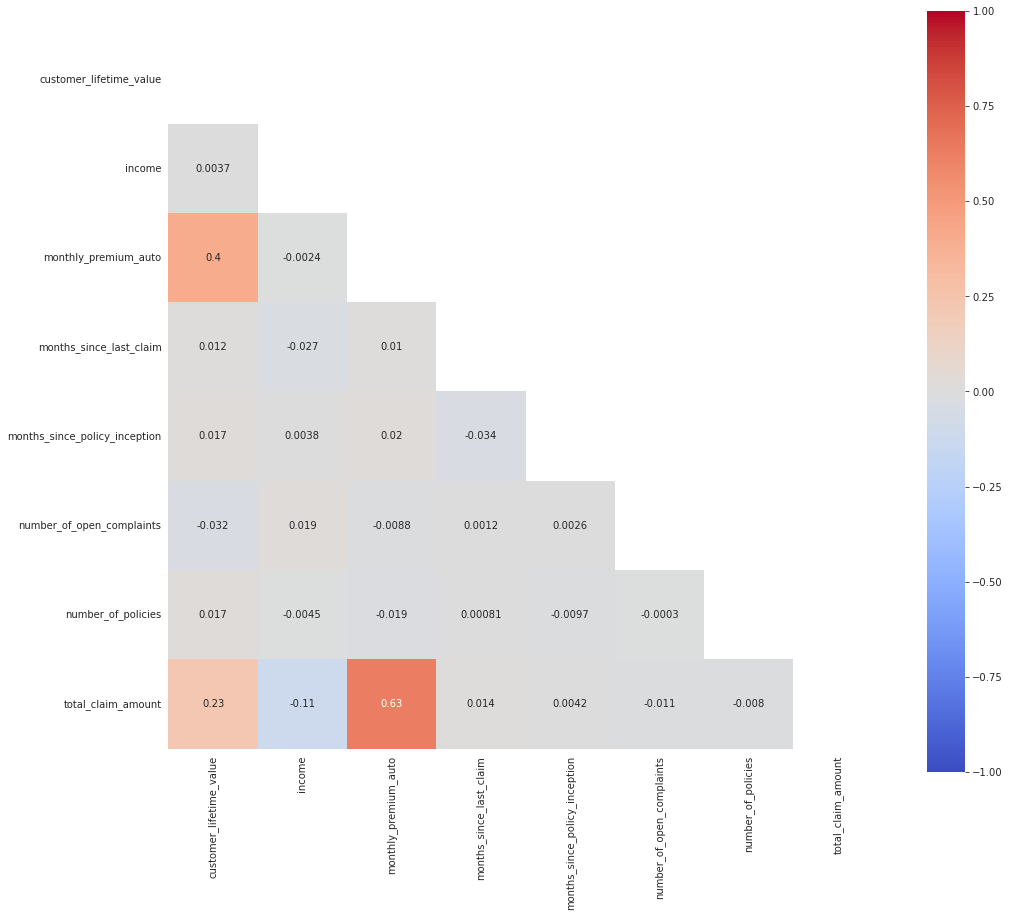

In [240]:
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True # trick to filter out the upper-right triangle, which is redundant due to symmetry
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 14))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

<b> removing highly correlated columns


In [241]:
CORR_THRESH = 0.80
#corr_matrix=hk_df.corr().abs()
corr_matrix=df.corr().abs()
upper_triangle=corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
corrd_cols = [column for column in upper_triangle.columns if any(upper_triangle[column] > CORR_THRESH)]
#hk_df.drop(corrd_cols,axis=1,inplace=True)
#hk_df.columns
df.drop(corrd_cols,axis=1,inplace=True)
df.columns

Index(['region', 'customer_lifetime_value', 'response', 'coverage',
       'education', 'effective_to_date', 'month', 'employment_status',
       'gender', 'income', 'location_code', 'marital_status',
       'monthly_premium_auto', 'months_since_last_claim',
       'months_since_policy_inception', 'number_of_open_complaints',
       'number_of_policies', 'policy_type', 'policy', 'renew_offer_type',
       'sales_channel', 'total_claim_amount', 'vehicle_class', 'vehicle_size'],
      dtype='object')

array([[<AxesSubplot:title={'center':'customer_lifetime_value'}>,
        <AxesSubplot:title={'center':'income'}>,
        <AxesSubplot:title={'center':'monthly_premium_auto'}>],
       [<AxesSubplot:title={'center':'months_since_last_claim'}>,
        <AxesSubplot:title={'center':'months_since_policy_inception'}>,
        <AxesSubplot:title={'center':'number_of_open_complaints'}>],
       [<AxesSubplot:title={'center':'number_of_policies'}>,
        <AxesSubplot:title={'center':'total_claim_amount'}>,
        <AxesSubplot:>]], dtype=object)

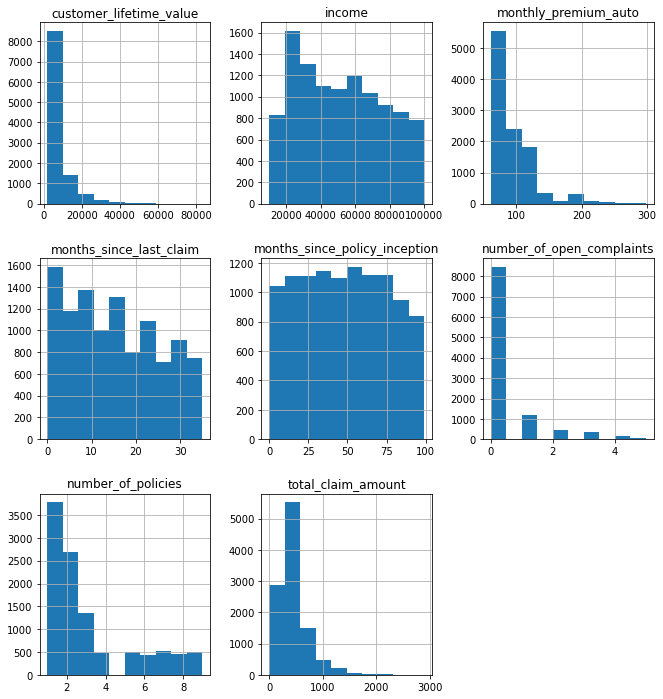

In [242]:
#hk_df.hist(figsize=(11,12))
df.hist(figsize=(11,12))

<b> distribution of home value is skewed towards lower incomes

In [243]:
#sns.distplot((hk_df['median_home_val']), bins=20)
#sns.distplot((df['median_home_val']), bins=20)

## X,y, standardScaler, and test/train

In [244]:
#X = hk_df.drop('target_d', axis=1)
#y = hk_df.target_d
numericalX = df.select_dtypes(np.number)
numericalX

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount
0,4809,48029,61,7,52,0,9,292
1,2228,92260,64,3,26,0,1,744
2,14947,22139,100,34,31,0,2,480
3,22332,49078,97,10,3,0,2,484
4,9025,23675,117,33,31,0,7,707
...,...,...,...,...,...,...,...,...
10684,15563,61541,253,12,40,0,7,1214
10685,5259,61146,65,7,68,0,6,273
10686,23893,39837,201,11,63,0,2,381
10687,11971,64195,158,0,27,4,6,618


In [245]:
#numericalX = hk_df.select_dtypes(np.number)
#categoricalX = X.select_dtypes(object)#X.select_dtypes("object")
#X = numericalX.drop('target_d', axis=1)
#y = numericalX.target_d
X = numericalX.drop('total_claim_amount', axis=1)
y = numericalX.total_claim_amount

In [246]:
#check NaNs
X.isna().any()

customer_lifetime_value          False
income                           False
monthly_premium_auto             False
months_since_last_claim          False
months_since_policy_inception    False
number_of_open_complaints        False
number_of_policies               False
dtype: bool

In [247]:
#remove any na
na_idcs = X[X.isna().any(axis=1)].index
X = pd.DataFrame(X).drop(na_idcs)
y = pd.DataFrame(y).drop(na_idcs)

In [248]:
#original dataset
#hk_df
df

,region,customer_lifetime_value,response,coverage,education,effective_to_date,month,employment_status,gender,income,...,months_since_policy_inception,number_of_open_complaints,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,total_claim_amount,vehicle_class,vehicle_size
0,central,4809,no,basic,college,2/18/11,feb,employed,m,48029,...,52,0,9,corporate auto,corporate l3,offer3,agent,292,four-door car,medsize
1,west region,2228,no,basic,college,1/18/11,jan,unemployed,f,92260,...,26,0,1,personal auto,personal l3,offer4,call center,744,four-door car,medsize
2,east,14947,no,basic,bachelor,2/10/11,feb,employed,m,22139,...,31,0,2,personal auto,personal l3,offer3,call center,480,suv,medsize
3,north west,22332,yes,extended,college,1/11/11,jan,employed,m,49078,...,3,0,2,corporate auto,corporate l3,offer2,branch,484,four-door car,medsize
4,north west,9025,no,premium,bachelor,1/17/11,jan,medical leave,f,23675,...,31,0,7,personal auto,personal l2,offer1,branch,707,four-door car,medsize
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10684,central,15563,no,premium,bachelor,1/19/11,jan,unemployed,f,61541,...,40,0,7,personal auto,personal l1,offer3,web,1214,luxury car,medsize
10685,north west,5259,no,basic,college,1/6/11,jan,employed,f,61146,...,68,0,6,personal auto,personal l3,offer2,branch,273,four-door car,medsize
10686,central,23893,no,extended,bachelor,2/6/11,feb,employed,f,39837,...,63,0,2,corporate auto,corporate l3,offer1,web,381,luxury suv,medsize
10687,west region,11971,no,premium,college,2/13/11,feb,employed,f,64195,...,27,4,6,personal auto,personal l1,offer1,branch,618,suv,medsize


In [249]:
#check target variable
y

,total_claim_amount
0,292
1,744
2,480
3,484
4,707
...,...
10684,1214
10685,273
10686,381
10687,618


In [250]:
numericalX

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount
0,4809,48029,61,7,52,0,9,292
1,2228,92260,64,3,26,0,1,744
2,14947,22139,100,34,31,0,2,480
3,22332,49078,97,10,3,0,2,484
4,9025,23675,117,33,31,0,7,707
...,...,...,...,...,...,...,...,...
10684,15563,61541,253,12,40,0,7,1214
10685,5259,61146,65,7,68,0,6,273
10686,23893,39837,201,11,63,0,2,381
10687,11971,64195,158,0,27,4,6,618


In [251]:
columns=numericalX.drop('total_claim_amount', axis=1)

columns=columns.columns
columns

Index(['customer_lifetime_value', 'income', 'monthly_premium_auto',
       'months_since_last_claim', 'months_since_policy_inception',
       'number_of_open_complaints', 'number_of_policies'],
      dtype='object')

Linear Regression
X-y split (y is the target variable, which is the total claim amount)
Train-test split.

In [252]:
#Train the model
# test-train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TT_RATIO, random_state=RAND_STATE)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_train.head(3)

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies
2705,4786,45515,61,10,33,0,9
2209,22445,80340,71,32,35,0,2
4004,6412,58776,83,20,50,2,4


In [253]:
X_test.head(3)

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies
5613,9035,34337,113,20,44,0,9
9585,4376,63774,111,18,63,0,1
2042,4428,58577,110,6,62,0,1


In [254]:
y_train.head(3)

,total_claim_amount
2705,236
2209,511
4004,478


In [255]:
y_test.head(3)

,total_claim_amount
5613,542
9585,60
2042,303


In [256]:
#from sklearn.preprocessing import StandardScaler
#data =  X_train
#data = np.array(data)#.reshape(-1,1)
#scaler = StandardScaler()
#std= scaler.fit(data)
#std= std.transform(data)
#std= pd.DataFrame(std)
#std.columns = columns
#std["customer_lifetime_value2"]=numerical["customer_lifetime_value"]
#std

In [257]:
from sklearn.preprocessing import StandardScaler
#X_train is the data
X_train = np.array(X_train)#.reshape(-1,1)
scaler = StandardScaler()
X_train_std= scaler.fit(X_train)
X_train_std= X_train_std.transform(X_train)
X_train_std= pd.DataFrame(X_train_std)
X_train_std.columns = columns
#std["customer_lifetime_value2"]=numerical["customer_lifetime_value"]
X_train_std

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies
0,-0.463463,-0.259427,-0.945841,-0.505684,-0.531276,-0.417180,2.489044
1,2.063006,1.144456,-0.653122,1.676281,-0.459758,-0.417180,-0.408773
2,-0.230831,0.275157,-0.301858,0.486118,0.076627,1.828387,0.419175
3,-0.825716,-0.119825,-0.828753,-0.803225,1.685783,-0.417180,-0.822747
4,-0.085616,-0.931316,0.078677,0.684479,0.219663,-0.417180,1.661096
...,...,...,...,...,...,...,...
7477,-0.196781,-0.309858,0.166492,0.089397,0.613013,1.828387,0.005201
7478,0.443313,-0.199805,0.547027,0.982020,0.756049,-0.417180,-0.408773
7479,-0.773781,1.870001,-0.828753,-0.208143,-0.531276,-0.417180,-0.822747
7480,-0.663618,-1.160775,-0.155499,-0.604864,-1.496770,1.828387,-0.822747


In [258]:
#y_train_std= scaler.fit(y_train)
#y_train_std= y_train_std.transform(y_train)
#y_train_std


In [259]:
#model fitting
model=LinearRegression()    # model
model.fit(X_train_std, y_train)   # model train


LinearRegression()

In [260]:
X_test=scaler.transform(X_test)
X_test

/Users/evansrono/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


array([[ 0.14444055, -0.71004053,  0.57629933, ..., -0.137927  ,
        -0.41717964,  2.48904378],
       [-0.52212155,  0.47663896,  0.51775548, ...,  0.54149453,
        -0.41717964, -0.82274665],
       [-0.51468192,  0.26713482,  0.48848355, ...,  0.5057355 ,
        -0.41717964, -0.82274665],
       ...,
       [-0.12567519,  1.43123929, -0.12622686, ...,  1.43547023,
        -0.41717964,  1.24712237],
       [-0.7420198 ,  0.78648094, -0.56530573, ...,  1.04212092,
         5.19673778, -0.82274665],
       [-0.80196604, -0.8159415 , -0.91656882, ..., -0.67431241,
        -0.41717964, -0.82274665]])

In [261]:
#model parameters
model.coef_

array([[-5.99598283e+00, -3.17043664e+01,  1.87098365e+02,
         2.05563615e+00, -6.47737048e-01, -5.95820844e-01,
        -1.54903758e-01]])

In [262]:
#model parameters
model.intercept_

array([435.82945736])

In [263]:
#make prediction
y_pred = pd.DataFrame(model.predict(X_test),columns = ['total_claim_amount'] )      # model prediction
y_pred_train =  pd.DataFrame(model.predict(X_train),columns = ['total_claim_amount'])


/Users/evansrono/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/evansrono/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [264]:
y_test=y_test.reset_index(drop=True)#To avoid NaNs

In [265]:
y_test

,total_claim_amount
0,542
1,60
2,303
3,552
4,345
...,...
3202,209
3203,355
3204,60
3205,93


In [267]:
pd.concat([y_pred,y_test], axis=1)

,total_claim_amount,total_claim_amount
0,566.251066,542
1,521.336547,60
2,520.034026,303
3,311.491636,552
4,345.702660,345
...,...,...
3202,269.441500,209
3203,360.514344,355
3204,369.753270,60
3205,305.096416,93


## WEDNESDAY_WEEK4: Model Validation

## Model Evaluation

(Wednesday)

Model Validation
Model Evaluation:
MSE.
RMSE.
MAE.
R2.
Adjusted R2.
Feature Importance.
Model Iteration (Wednesday and Thursday)
Please rerun the model after adding the hot encoded categorical variables as well as other numeric categroical variables (e.g. number of open complaintes).
(Optional) Please rerun the model after removing the outliers and compare the results using R2 metric.

## MSE

# Calculate MSE

In [268]:
y_test

,total_claim_amount
0,542
1,60
2,303
3,552
4,345
...,...
3202,209
3203,355
3204,60
3205,93


In [269]:
#y-test
print(mse(y_test,y_pred))


52330.37932325502


# Calculate RMSE

In [270]:
# Calculate mean squared error
mse = mse(y_test,y_pred)

# Calculate root mean squared error
rmse = np.sqrt(mse)

print("RMSE:", rmse)

RMSE: 228.75834263094106


# Calculate MAE: Mean Absolute Error

In [271]:
mae = mae(y_test,y_pred)

print("Mean Absolute Error:", mae)

Mean Absolute Error: 153.89185609233465


# Calculate R2 score

In [272]:
r2 = r2_score(y_test,y_pred)
# print result
print(f"R2 score: {r2:.2f}")

R2 score: 0.40


In [273]:
# Calculate adjusted R-squared value

In [274]:
# calculate the R-squared value
r2 = r2_score(y_test,y_pred)

# calculate the number of features (p) and number of observations (n)
p = X.shape[1]
n = X.shape[0]

# calculate the adjusted R-squared value
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print("Adjusted R-squared: ", adjusted_r2)

Adjusted R-squared:  0.39953062728526356


# Feature Importance. 

In [278]:
X_train_std

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies
0,-0.463463,-0.259427,-0.945841,-0.505684,-0.531276,-0.417180,2.489044
1,2.063006,1.144456,-0.653122,1.676281,-0.459758,-0.417180,-0.408773
2,-0.230831,0.275157,-0.301858,0.486118,0.076627,1.828387,0.419175
3,-0.825716,-0.119825,-0.828753,-0.803225,1.685783,-0.417180,-0.822747
4,-0.085616,-0.931316,0.078677,0.684479,0.219663,-0.417180,1.661096
...,...,...,...,...,...,...,...
7477,-0.196781,-0.309858,0.166492,0.089397,0.613013,1.828387,0.005201
7478,0.443313,-0.199805,0.547027,0.982020,0.756049,-0.417180,-0.408773
7479,-0.773781,1.870001,-0.828753,-0.208143,-0.531276,-0.417180,-0.822747
7480,-0.663618,-1.160775,-0.155499,-0.604864,-1.496770,1.828387,-0.822747


In [275]:
#Please rerun the model after adding the hot encoded categorical variables 
#as well as other numeric categroical variables (e.g. number of open complaintes).
#(Optional) Please rerun the model after removing the outliers and compare the results using R2 metric.

In [302]:
#To check just the impact only on absolute values
features_importances = pd.DataFrame(data={
    'Attribute': X_train_std.columns,
    'Importance': abs(model.coef_.reshape(len(X_train_std.columns),))
})
features_importances = features_importances.sort_values(by='Importance', ascending=False)
features_importances

,Attribute,Importance
2,monthly_premium_auto,187.098365
1,income,31.704366
0,customer_lifetime_value,5.995983
3,months_since_last_claim,2.055636
4,months_since_policy_inception,0.647737
5,number_of_open_complaints,0.595821
6,number_of_policies,0.154904


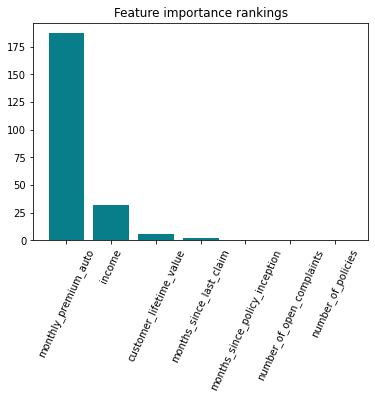

In [303]:
plt.bar(x=features_importances['Attribute'].iloc[:10], height=features_importances['Importance'].iloc[:10], color='#087E8B')
plt.title('Feature importance rankings', size=12)
plt.xticks(rotation=65)#plt.xticks(rotation='vertical')
plt.show()

In [304]:
#To check also the type of theimpact if it negatively or positive affect the target variable
features_importances = pd.DataFrame(data={
    'Attribute': X_train_std.columns,
    'Importance':(model.coef_.reshape(len(X_train_std.columns),))
})
features_importances = features_importances.sort_values(by='Importance', ascending=False)
features_importances

,Attribute,Importance
2,monthly_premium_auto,187.098365
3,months_since_last_claim,2.055636
6,number_of_policies,-0.154904
5,number_of_open_complaints,-0.595821
4,months_since_policy_inception,-0.647737
0,customer_lifetime_value,-5.995983
1,income,-31.704366


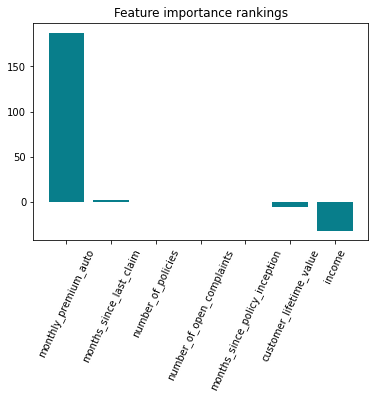

In [305]:
#To check also the type of theimpact if it negatively or positive affect the target variable
plt.bar(x=features_importances['Attribute'].iloc[:10], height=features_importances['Importance'].iloc[:10], color='#087E8B')
plt.title('Feature importance rankings', size=12)
plt.xticks(rotation=65)#plt.xticks(rotation='vertical')
plt.show()

,Attribute,Importance
2,monthly_premium_auto,187.098365
3,months_since_last_claim,2.055636
6,number_of_policies,-0.154904
5,number_of_open_complaints,-0.595821
4,months_since_policy_inception,-0.647737
0,customer_lifetime_value,-5.995983
1,income,-31.704366


# Model Iteration (Wednesday and Thursday)

In [309]:
#select  gategorical colums
#df.drop("effective_to_date", axis=1, inplace=True) 
#df
categoricals=df.select_dtypes(include = "object")
#categoricals=df.select_dtypes(include= 'object' ).columns

categoricals


,region,response,coverage,education,month,employment_status,gender,location_code,marital_status,policy_type,policy,renew_offer_type,sales_channel,vehicle_class,vehicle_size
0,central,no,basic,college,feb,employed,m,suburban,married,corporate auto,corporate l3,offer3,agent,four-door car,medsize
1,west region,no,basic,college,jan,unemployed,f,suburban,single,personal auto,personal l3,offer4,call center,four-door car,medsize
2,east,no,basic,bachelor,feb,employed,m,suburban,single,personal auto,personal l3,offer3,call center,suv,medsize
3,north west,yes,extended,college,jan,employed,m,suburban,single,corporate auto,corporate l3,offer2,branch,four-door car,medsize
4,north west,no,premium,bachelor,jan,medical leave,f,suburban,married,personal auto,personal l2,offer1,branch,four-door car,medsize
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10684,central,no,premium,bachelor,jan,unemployed,f,suburban,married,personal auto,personal l1,offer3,web,luxury car,medsize
10685,north west,no,basic,college,jan,employed,f,urban,married,personal auto,personal l3,offer2,branch,four-door car,medsize
10686,central,no,extended,bachelor,feb,employed,f,rural,married,corporate auto,corporate l3,offer1,web,luxury suv,medsize
10687,west region,no,premium,college,feb,employed,f,urban,divorced,personal auto,personal l1,offer1,branch,suv,medsize


In [310]:
from sklearn.preprocessing import OneHotEncoder
# define data
data = categoricals[["region","response","coverage","month","employment_status","gender","location_code","marital_status",
                     "policy_type","policy","renew_offer_type","sales_channel","vehicle_class","vehicle_size"]]
#print(data)
# define one hot encoding
encoder = OneHotEncoder(sparse=False)
# transform data
onehot = encoder.fit_transform(data)
#print(onehot)
onehot
#

onehot = pd.DataFrame(onehot)
onehot

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10684,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10685,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10686,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
10687,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [296]:
nominal = categoricals[["region","response","coverage","month","employment_status","gender","location_code","marital_status",
                      "policy_type","policy","renew_offer_type","sales_channel","vehicle_class","vehicle_size"]]
#nominal=pd.get_dummies(nominal, drop-first=True)
nominal=pd.get_dummies(nominal)
#nominal=pd.get_dummies(nominal, drop_first =True)
nominal
nominal

,region_central,region_east,region_north west,region_west region,response_no,response_yes,coverage_basic,coverage_extended,coverage_premium,month_feb,...,sales_channel_web,vehicle_class_four-door car,vehicle_class_luxury car,vehicle_class_luxury suv,vehicle_class_sports car,vehicle_class_suv,vehicle_class_two-door car,vehicle_size_large,vehicle_size_medsize,vehicle_size_small
0,1,0,0,0,1,0,1,0,0,1,...,0,1,0,0,0,0,0,0,1,0
1,0,0,0,1,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,0,1,0,0,1,0,1,0,0,1,...,0,0,0,0,0,1,0,0,1,0
3,0,0,1,0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
4,0,0,1,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10684,1,0,0,0,1,0,0,0,1,0,...,1,0,1,0,0,0,0,0,1,0
10685,0,0,1,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
10686,1,0,0,0,1,0,0,1,0,1,...,1,0,0,1,0,0,0,0,1,0
10687,0,0,0,1,1,0,0,0,1,1,...,0,0,0,0,0,1,0,0,1,0


In [317]:
categorical = pd.get_dummies(categoricals, prefix = ['month', 'region','response', 'employment_status', 'gender', 'location_code', 'policy_type', 'marital_status','policy', 'renew_offer_type', 'sales_channel'], columns = ['month', 'region','response', 'employment_status', 'gender', 'policy_type', 'location_code', 'marital_status', 'policy', 'renew_offer_type', 'sales_channel'], drop_first=False)
categorical
categorical = categorical.drop(["coverage","education","vehicle_class","vehicle_size"], axis=1)
categorical

,month_feb,month_jan,region_central,region_east,region_north west,region_west region,response_no,response_yes,employment_status_disabled,employment_status_employed,...,policy_special l2,policy_special l3,renew_offer_type_offer1,renew_offer_type_offer2,renew_offer_type_offer3,renew_offer_type_offer4,sales_channel_agent,sales_channel_branch,sales_channel_call center,sales_channel_web
0,1,0,1,0,0,0,1,0,0,1,...,0,0,0,0,1,0,1,0,0,0
1,0,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,1,0,0,1,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,1,0
3,0,1,0,0,1,0,0,1,0,1,...,0,0,0,1,0,0,0,1,0,0
4,0,1,0,0,1,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10684,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
10685,0,1,0,0,1,0,1,0,0,1,...,0,0,0,1,0,0,0,1,0,0
10686,1,0,1,0,0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,1
10687,1,0,0,0,0,1,1,0,0,1,...,0,0,1,0,0,0,0,1,0,0


In [338]:
df = pd.concat([categorical, numericalX], axis=1).reset_index(drop=True)
df

,month_feb,month_jan,region_central,region_east,region_north west,region_west region,response_no,response_yes,employment_status_disabled,employment_status_employed,...,sales_channel_call center,sales_channel_web,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount
0,1,0,1,0,0,0,1,0,0,1,...,0,0,4809,48029,61,7,52,0,9,292
1,0,1,0,0,0,1,1,0,0,0,...,1,0,2228,92260,64,3,26,0,1,744
2,1,0,0,1,0,0,1,0,0,1,...,1,0,14947,22139,100,34,31,0,2,480
3,0,1,0,0,1,0,0,1,0,1,...,0,0,22332,49078,97,10,3,0,2,484
4,0,1,0,0,1,0,1,0,0,0,...,0,0,9025,23675,117,33,31,0,7,707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10684,0,1,1,0,0,0,1,0,0,0,...,0,1,15563,61541,253,12,40,0,7,1214
10685,0,1,0,0,1,0,1,0,0,1,...,0,0,5259,61146,65,7,68,0,6,273
10686,1,0,1,0,0,0,1,0,0,1,...,0,1,23893,39837,201,11,63,0,2,381
10687,1,0,0,0,0,1,1,0,0,1,...,0,0,11971,64195,158,0,27,4,6,618


In [333]:
#Remove outliers
df= remove_outliers(df).reset_index(drop=False)#To avoid NaNs
df

,level_0,index,month_feb,month_jan,region_central,region_east,region_north west,region_west region,response_no,response_yes,...,sales_channel_call center,sales_channel_web,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount
0,0,0,1,0,1,NaN,0,0,NaN,NaN,...,NaN,NaN,NaN,48029,NaN,7,52,NaN,NaN,NaN
1,1,1,0,1,0,NaN,0,1,NaN,NaN,...,NaN,NaN,NaN,92260,NaN,3,26,NaN,NaN,NaN
2,2,2,1,0,0,NaN,0,0,NaN,NaN,...,NaN,NaN,NaN,22139,NaN,34,31,NaN,NaN,NaN
3,3,3,0,1,0,NaN,1,0,NaN,NaN,...,NaN,NaN,NaN,49078,NaN,10,3,NaN,NaN,NaN
4,4,4,0,1,0,NaN,1,0,NaN,NaN,...,NaN,NaN,NaN,23675,NaN,33,31,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10684,10684,10684,0,1,1,NaN,0,0,NaN,NaN,...,NaN,NaN,NaN,61541,NaN,12,40,NaN,NaN,NaN
10685,10685,10685,0,1,0,NaN,1,0,NaN,NaN,...,NaN,NaN,NaN,61146,NaN,7,68,NaN,NaN,NaN
10686,10686,10686,1,0,1,NaN,0,0,NaN,NaN,...,NaN,NaN,NaN,39837,NaN,11,63,NaN,NaN,NaN
10687,10687,10687,1,0,0,NaN,0,1,NaN,NaN,...,NaN,NaN,NaN,64195,NaN,0,27,NaN,NaN,NaN


# Model
# X-y split & train and test split

In [340]:
# x-y split
X = df.drop('total_claim_amount', axis=1)
y = df.total_claim_amount

In [341]:
# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TT_RATIO, random_state=RAND_STATE)#RAND_STATE = 34 # for reproducible shuffling
#TT_RATIO = 0.3 # test/train
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

# Standardscaler on categoricals and numericals

In [342]:
# scale train and test (fit & transform train; only transform test)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # the standard scaler will only work with numericals
X_test_scaled = scaler.transform(X_test)

In [343]:
# train model
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
lr.coef_
lr.intercept_

435.7016867917168

In [344]:
# predict
y_lr_train_pred =  pd.DataFrame(lr.predict(X_train_scaled), columns = ['total_claim_amount'])
y_lr_test_pred = pd.DataFrame(lr.predict(X_test_scaled), columns = ['total_claim_amount'])

In [345]:
# model performance
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

lr_train_mse = mean_squared_error(y_train, y_lr_train_pred)
lr_train_mae = mean_absolute_error(y_train, y_lr_train_pred)
lr_train_r2 = r2_score(y_train, y_lr_train_pred)
lr_train_ar2 = 1 - (1 - lr_train_r2) * (len(y_train) -1) / (len(y_train) - X_train.shape[1] - 1)
    # has X_train to be the scaled one?

lr_test_mse = mean_squared_error(y_test, y_lr_test_pred)
lr_test_mae = mean_absolute_error(y_test, y_lr_test_pred)
lr_test_r2 = r2_score(y_test, y_lr_test_pred)
lr_test_ar2 = 1 - (1 - lr_test_r2) * (len(y_test) -1) / (len(y_test) - X_test.shape[1] - 1)


lr_results = pd.DataFrame(['Linear Regression', lr_train_mse, lr_test_mse, lr_train_mae, lr_test_mae, lr_train_r2, lr_test_r2, lr_train_ar2, lr_test_ar2]).transpose()
lr_results.columns = ['Method', 'Training MSE', 'Test MSE', 'Training MAE', 'Test MAE', 'Training R2', 'Test R2', 'Training Ad. R2', 'Test Ad. R2']

lr_results
# error_train < error_test => model ok!

,Method,Training MSE,Test MSE,Training MAE,Test MAE,Training R2,Test R2,Training Ad. R2,Test Ad. R2
0,Linear Regression,19441.103934,20857.979686,95.739007,97.914109,0.770935,0.76082,0.769456,0.757185


# Visualisations

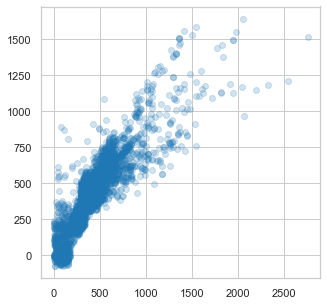

In [346]:
# scatterplot y_test, y_pred
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_lr_test_pred, alpha = 0.2)

<AxesSubplot:>

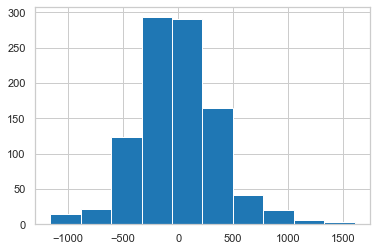

In [347]:
# histogram residuals
residuals = y_test - y_lr_test_pred.total_claim_amount
residuals.hist()

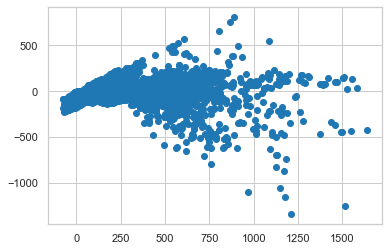

In [348]:
# scatterplot residuals
y_test = y_test.to_numpy().reshape(-1,1)

residuals_error = y_lr_test_pred.to_numpy() - y_test
plt.scatter(y_lr_test_pred, residuals_error)

In [349]:
features_importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': abs(lr.coef_.reshape(len(X_train.columns),))
})
features_importances = features_importances.sort_values(by='Importance', ascending=False)
features_importances

,Attribute,Importance
26,policy_corporate l3,6.069872e+15
25,policy_corporate l2,4.747511e+15
24,policy_corporate l1,3.732650e+15
37,sales_channel_agent,3.706216e+15
15,location_code_corporate auto,3.697533e+15
16,location_code_personal auto,3.448167e+15
38,sales_channel_branch,3.445741e+15
39,sales_channel_call center,3.020615e+15
19,policy_type_suburban,2.915008e+15
40,sales_channel_web,2.755507e+15


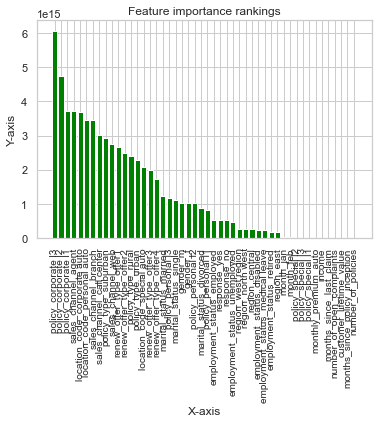

<Figure size 720x432 with 0 Axes>

In [368]:
plt.bar(x=features_importances['Attribute'].iloc[:50], height=features_importances['Importance'].iloc[:50], color='green',width=0.8)
plt.title('Feature importance rankings', size=12)
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.xticks(fontsize=10, rotation=90)#(rotation='vertical')
plt.figure(figsize=(10, 6))


plt.show()

In [369]:

t= -1.75
tc=scipy.stats.t.ppf(0.95,df=24)
tc

NameError: name 'scipy' is not defined